# Neural machine translation with attention

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation

## Installing Dependencies

## Import Dependencies

In [1]:
import numpy as np 
import typing 
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

import tensorflow as tf 
import tensorflow_text as tf_text 

from utils import ShapeChecker

In [2]:
tf.config.list_physical_devices('GPU')

[]

## Download Data

In [3]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True
)

# `pathlib.Path(path_to_zip)` converts the path_to_zip string into a Path object
# `.parent` navigates to the parent directory of the current path 
# `/'spa-eng/spa.txt'` Uses the / operator to the parent directory path with 'spa-eng/spa.txt'
path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [4]:
def load_data(path): 
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context

In [5]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [6]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


## Create a tf.data dataset

From these arrays of strings you can create a tf.data.Dataset of strings that shuffles and batches them efficiently

In [7]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

# Generates an array of random numbers
# Each number is uniformly distributed between 0 and 1 
# The size of the array matches the length of target_raw 
# Practical meaning:
# Randomly splits data into train and test sets
# Approximately 80% of the data will be True (for training)
# Approximately 20% of the data will be False (for testing)
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

is_train[0]

True

In [8]:
train_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train])) # creates tensorflow dataset, uses is_train boolean mask to select training data
    .shuffle(BUFFER_SIZE) # randomly shuffles data, helps prevent model from learning order-specific patterns, improves model generalization
    .batch(BATCH_SIZE) # splits data into fixed-size batches, allows effifcient paraller processing during training, helps in gradient descent optimizaition
)

val_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train])) # creates tensorflow dataset, Uses the boolean mask to pick data points NOT selected for training
    .shuffle(BUFFER_SIZE) # randomly shuffles data, helps prevent model from learning order-specific patterns, improves model generalization
    .batch(BATCH_SIZE) # splits data into fixed-size batches, allows effifcient paraller processing during training, helps in gradient descent optimizaition
)

In [9]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Abandona mientras puedes.' b'En ese momento estaba viendo la tele.'
 b'Pienso que esto es realmente excitante.'
 b'Has lo que te dicte tu coraz\xc3\xb3n.' b'Llamen a una ambulancia.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Leave while you can.' b'I was watching TV then.'
 b'I think this is really exciting.' b'Do as your heart dictates.'
 b'Call an ambulance.'], shape=(5,), dtype=string)


## Text Preprocessing 

One of the goals of this tutorial is to build a model that can be exported as a tf.saved_model. To make that exported model useful it should take tf.string inputs, and return tf.string outputs: All the text processing happens inside the model. Mainly using a layers.TextVectorization layer.

### Standarization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.
The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

In [10]:
example = tf.constant('¿Todavía está en casa?')
print(example.numpy())
print(tf_text.normalize_utf8(example, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function

In [11]:
def tf_lower_and_split_punct(text): 
    text = tf_text.normalize_utf8(text, 'NFKD') # normalizes unicode text 
    
    text = tf.strings.lower(text) # converts entire text to lowercase

    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]','') # regex replacement to remove unwanted characters, Keep space , a to z and select punctuation 

    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ') # adds spaces around punctuation marks

    text = tf.strings.strip(text) # removes leading and trailing whitespaces, ensures clean text formatting

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ') # adds special token to beginning and end of text, [START] and [END] mark text boundaries

    return text 

In [12]:
print(example.numpy().decode())
print(tf_lower_and_split_punct(example).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


## Text Vectorization

This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [13]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size, 
    ragged=True
)

The TextVectorization layer and many other Keras preprocessing layers have an adapt method. This method reads one epoch of the training data, and works a lot like Model.fit. This adapt method initializes the layer based on the data. Here it determines the vocabulary

In [14]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

context_text_processor.get_vocabulary()[:20] # Get the first 20 words from the vocabulary

2024-12-12 09:48:45.844733: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'que',
 'de',
 'el',
 'a',
 'no',
 'tom',
 'la',
 '?',
 '¿',
 'en',
 'es',
 'un',
 'se',
 'me',
 ',']

That's the Spanish TextVectorization layer, now build and .adapt() the English one

In [15]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, 
    max_tokens=max_vocab_size, 
    ragged=True
)

target_text_processor.adapt(train_raw.map(lambda context, target: target))

target_text_processor.get_vocabulary()[:20]

2024-12-12 09:48:47.625649: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'the',
 'i',
 'to',
 'you',
 'tom',
 'a',
 '?',
 'is',
 'he',
 'in',
 'of',
 'that',
 'it',
 'was',
 ',']

#### Now these layers can convert a batch of strings into a batch of token IDs

In [16]:
example_tokens = context_text_processor(example_context_strings)

In [17]:
example_tokens[:3, :]

<tf.RaggedTensor [[2, 1, 353, 106, 4, 3], [2, 14, 98, 274, 47, 952, 11, 1201, 4, 3],
 [2, 387, 5, 56, 15, 192, 1, 4, 3]]>

The get_vocabulary method can be used to convert token IDs back to text

In [18]:

context_vocab = np.array(context_text_processor.get_vocabulary()) # retrieves the vocabulary from the text processor, converts it to numpy array
tokens = context_vocab[example_tokens[0].numpy()] # uses token indices to lookup actual words, converts numeric representation back to human-readable text

' '.join(tokens)

'[START] [UNK] mientras puedes . [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask

Text(0.5, 1.0, 'Mask')

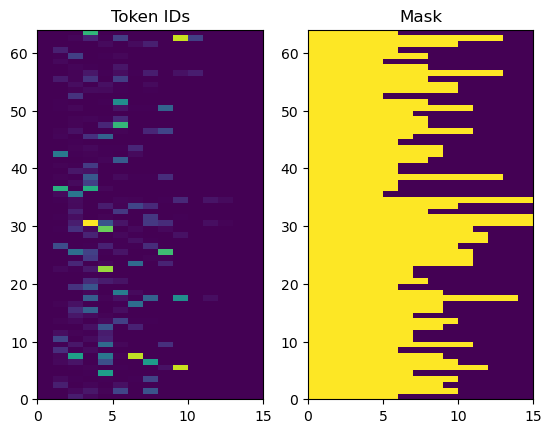

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

## Processing

The `process_text` function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the `labels` are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [20]:
def process_text(context, target): 
    context = context_text_processor(context).to_tensor() # first, encode the context text data, and then convert it into tf tensor
    target = target_text_processor(target) # encode the target text data

    targ_in = target[:, :-1].to_tensor() # first, create the input target sequence by taking all but the last element of the target data, and then convert it into tf tensor
    targ_out = target[:,1:].to_tensor() # first, create the input target sequence by taking all but the first element of the target data, and then convert it into tf tensor

    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [21]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   11  153   20 1066    6    1    4    3    0]

[  2 216  12 533  15   1   4   0   0   0]
[216  12 533  15   1   4   3   0   0   0]


## The Encoder/Decoder

In [22]:
UNITS = 256

### Encoder

The goal of the encoder is to process the context sequence into a set of vectors that will be helpful for the decoder. The decoder will use these vectors to predict the next output at each time step.

Since the input sequence does not change during the process, the encoder can use a bidirectional recuurent neural network to do the processing.

A Bi-RNN processes the input sequence in both the forward and backward directions. This allows the encoder to capture information from the entire input sequence, which can be useful for the decoder when predicting the output.
The key points are:

1. The encoder converts the input sequence into a set of helpful vectors.
2. The encoder uses a Bi-RNN to process the input in both directions.
3. This bidirectional processing allows the encoder to leverage information from the whole input sequence.
4. The decoder then uses these encoded vectors to predict the output sequence.

In [23]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units
        self.shape_checker = ShapeChecker()
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))
    
    def call(self, x):
        # self.shape_checker(x, 'batch s')
        
        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        # self.shape_checker(x, 'batch s units')
        
        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        # self.shape_checker(x, 'batch s units')
        
        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        print('is running!!')
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [24]:
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 256)


## The Attention Layer

Think of attention like a smart lookup system. When the decoder needs to create its output, it uses attention to figure out which parts of the encoded input are most relevant right now. Instead of just taking a simple average of all the input information, attention calculates how important each piece of input is for the current task and creates a weighted combination - giving more weight to the important parts and less to the irrelevant ones.

In [25]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [26]:
attention_layer = CrossAttention(UNITS)

In [27]:
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True)

ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Attention result, shape (batch, t, units): (64, 18, 256)
Attention weights, shape (batch, t, s):    (64, 18, 20)


/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


The attention weights will sum to 1 over the context sequence, at each location in the target sequence

In [28]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.0000001, 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ],
      dtype=float32)

Here are the attention weights across the context sequences at t=0:

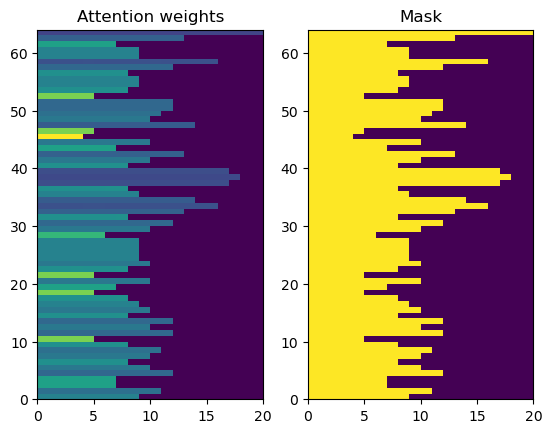

In [29]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

#### Conclusions from the Above Plots 

- The first plot shows the "Attention weights". At the start of training, these weights are all about the same, around 1 divided by the length of the input sequence. This means the model is initially paying equal attention to all parts of the input.

- However, as the model trains more, the attention weights start to become less uniform. Some parts of the input get higher weights, while others get lower weights. This means the model is learning to focus more on the important parts of the input and pay less attention to the less relevant parts.

- The second plot shows the "Mask". This represents how the model is selecting which parts of the input to focus on. Initially, the mask is fairly even, but as training progresses, the mask becomes more irregular and jagged. This indicates the model is becoming more selective in where it pays attention.

- Overall, these two plots demonstrate how the attention mechanism in the model is evolving during training. It starts off paying equal attention to everything, but gradually learns to focus on the most important parts of the input for the given task. This is an important part of how attention-based models like transformers work.


### Decoder

The decoder's job is to predict the next word in the output sequence, one word at a time.
Here's how it does that:

1. It looks up the embeddings (representations) for each word in the target sequence.
2. It uses a type of neural network called an RNN to process the target sequence. This helps the model keep track of what it has generated so far.
3. The RNN output is used as the "query" when attending to the encoder's output. This helps the decoder focus on the relevant parts of the input.
4. At each location in the output, the model predicts what the next word should be.

When training the model, it predicts the next word at each step. This is important because the information can only flow in one direction through the model - the decoder uses a unidirectional RNN.
During inference (when actually using the model), it generates one word at a time, and feeds those words back into the model to predict the next word.
The key points are that the decoder generates the output one word at a time, uses an RNN to keep track of what it has generated, and attends to the encoder's output to make its predictions.


In [30]:
class Decoder(tf.keras.layers.Layer):
    # A utility decorator that allows adding methods to the class dynamically
    @classmethod 
    def add_method(cls, fun): 
        setattr(cls, fun.__name__, fun)
        return fun
    def __init__(self, text_processor, units): 
        super(Decoder, self).__init__()

        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()

        # Converts words to numeric ids
        # The vocabulary argument is a list of all the words in the input and target sequences.
        # The mask_token and oov_token arguments specify the tokens that are used to mask and represent out-of-vocabulary words, respectively.
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(), 
            mask_token='', 
            oov_token='[UNK]'
        )

        # Converts Ids to their corresponding words 
        # the invert argument is set to true to indicate that this layer 
        # will be used to convert IDs to words 
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(), 
            mask_token='', 
            oov_token='[UNK]', 
            invert=True
        )

        # Special token to indicate sequence start
        self.start_token = self.word_to_id('[START]')

        # Special token to indicate sequence end
        self.end_token = self.word_to_id('[END]')

        # number of units in decoder 
        self.units = units 

        # Embedding layer - Converts token IDs to dense vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # GRU layer for sequence processing
        self.rnn = tf.keras.layers.GRU(units, 
                                      return_sequences=True,
                                      return_state=True, 
                                      recurrent_initializer='glorot_uniform')

        # Attention mechanism to focus on relevant parts of input
        self.attention = CrossAttention(units)

        # Final Dense layer to convert to vocabulary size 
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

        

        

### Training

Next, we will create the `call` method for the decoder class

In [31]:
@Decoder.add_method # custom decortor to add this method to the decoder class
def call(self, context, x , state=None, return_state=False):
    # Shape Validation 
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t') # validates input shape - batch size * time steps
    shape_checker(context, 'batch s units') # validates context shape - batch size * source length * units

    # Embedding Lookup
    x = self.embedding(x) # convert input tokens to embeddings
    shape_checker(x, 'batch t units') # verify shape: batch * time steps * embedding dims

    # RNN Processing 
    x, state = self.rnn(x, initial_state=state) # process sequence through GRU
    shape_checker(x, 'batch t units') # verify RNN output shape

    # Attention mechanism 
    x = self.attention(x, context) # apply attention using rnn output as query
    self.last_attention_weights = self.attention.last_attention_weights # store attention weights
    shape_checker(x, 'batch t units') # verify attention output shape
    shape_checker(self.last_attention_weights, 'batch t s')

    # Output Generation 
    logits = self.output_layer(x) # generate vocabulary distribution
    shape_checker(logits, 'batch t target_vocab_size') # verify final output shape

    if return_state: 
        return logits, state # return both predictions and RNN state
    else: 
        return logits



        

In [32]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token.

In [33]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape{ex_context.shape}')
print(f'input target tokens shape {ex_tar_in.shape}')
print(f'logits shape shape {logits.shape}')

encoder output shape(64, 20, 256)
input target tokens shape (64, 18)
logits shape shape (64, 18, 5000)


/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'decoder' (of type Decoder) was passed an input with

### Inference 
To use it for inference, we`ll need a couple more methods

In [34]:
# The function serves to initialize decoder`s sequence for sequence generation
@Decoder.add_method
def get_initial_state(self, context): 
    batch_size = tf.shape(context)[0] # get the batch size from the first dimension of the context tensor 
    start_tokens = tf.fill([batch_size, 1], self.start_token) # create a tensor filled with start_token for each item in the batch
    done = tf.zeros([batch_size, 1], dtype=tf.bool) # creates a boolean tensor initialized with FALSE values for tracking completion
    embedded = self.embedding(start_tokens) # convert start_tokens to embeddings

    # Get initial state from RNN
    # Instead of using get_initial_state directly, we'll use zeros with proper shape
    initial_state = tf.zeros([batch_size, self.units])

    return start_tokens, done, initial_state


    

In [35]:
# The function serves to convert numeric tokens back into text 
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens) # convert token IDs back to words using id_to_word lookup layer

    res = tf.strings.reduce_join(words, axis=-1, separator=' ') # join all words with spaces bw them
    res = tf.strings.regex_replace(res, '^ *\[START\] *', '') # remove START token and surrounding spaces from the beginning
    res = tf.strings.regex_replace(res, '^ *\[END\] *$', '') # remove END token and surrounding spaces from the end

    return res 

    

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

When temperature > 0: 
1. The logits (raw scores) are divided by the temperature value.
   - Higher temperature (>1.0) makes the distribution more uniform/random
   - Lower temperature (<1.0) makes the distribution more peaked/focused
2. tf.random.categorical samples from this modified distribution

 Think of temperature like this:
- temperature = 0.0: Always picks the most probable token (deterministic)
- temperature = 1.0: Samples according to the original probability distribution
- temperature > 1.0: More random/creative sampling
- temperature < 1.0: More conservative sampling, closer to greedy selection

Now, we are ready to write a generation loop 

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'protected credit lead troubles dawn horse shares begins hoping promising',
       b'flashlight oak subway including mile prevented hydrogen hoped hell stake',
       b'recently india graduate alcoholic could potatoes yawn speechless receiving call'],
      dtype=object)

#### Since the model's untrained, it outputs items from the vocabulary almost uniformly at random

## The Model

In [38]:
# Now, We create a translator class whose purpopse is to combine an encoder and decoder to process inputabs
# sequences and generate corresponding output sequences

class Translator(tf.keras.Model): 
    # A utility decorator that allows adding methods to the class dynamically
    @classmethod
    def add_method(cls, fun): 
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units, context_text_processor, target_text_processor): 
        super().__init__()

        # Build Encoder and Decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):

        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        try: 
            del logits._keras_mask
        except AttributeError: 
            pass 

        return logits
        

During Training, the Model will be used like this

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input 

Context tokens, shape: (batch, s, units) (64, 20)
Target tokens, shape: (batch, t) (64, 18)
logits, shape: (batch, t, target_vocabulary_size) (64, 18, 5000)


## Train

For training, you'll want to implement your own masked loss and accuracy functions:

Now, We will create a custom loss function used in seq2seq models or other tasks that involve variable length sequences and padding. It serves two main purposes: 

- **Ignore Losses from Padding Tokens**: In sequence-to-sequence tasks, input sequences are often padded to a fixed length to create batches of data. However, during training, we want to ignore the loss contributions from these padding tokens, as they don't represent actual data.
- **Calculate the Average Loss over Non-Padding Tokens**: Instead of calculating the total loss over the entire batch, which would include losses from padding tokens, this function calculates the average loss only over the non-padding tokens, giving a more accurate representation of the model's performance.

In [40]:
def masked_loss(y_true, y_pred): 
    # Calculate the loss for each item in the batch using SparseCategoricalCrossentropy
    # from_logits-True indicates that y_pred contains unscaled logits (instead of probabilities)
    # reduction=None specifies that the loss should be calculates for each individual element
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Create a boolean mask tensor where True represents non-padding elements 
    # y_true != 0 evaluates to a boolean tensor with True where y_true is non-zero 
    # tf.cast converts the boolean tensor to the same data type as loss
    mask = tf.cast(y_true != 0, loss.dtype)

    # Apply the mask to the loss tensor, setting losses for padding elements to 0 
    loss *= mask 

    # Calculate the final loss by summing the masked losses and normalizing by the 
    # number of non-padding elements 
    # tf.reduce_sum(loss) sums all the masked loss values
    # tf.reduce_sum(mask) counts the number of non-padding elements
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [41]:
def masked_accuracy(y_true, y_pred):
    # Calculate the loss for each item in the batch 
    # Take the argmax of y_pred along the last dimension to get the predicted class indices
    y_pred = tf.argmax(y_pred, axis=-1)

    # cast the predicted class indices to the same data type as y_true
    y_pred = tf.cast(y_pred, y_true.dtype)

    # compute the match bw y_true and y_pred, and cast to float32 
    match = tf.cast(y_true == y_pred, tf.float32)

    # create a mask to ignore padding values in y_true
    mask = tf.cast(y_true != 0, tf.float32)

    # calculate the sum of matches, divided by the sum of non-padding values in y_true
    return tf.reduce_sum(match) / tf.reduce_sum(mask)

### Compile the Model

In [42]:
model.compile(optimizer='adam', loss=masked_loss, metrics=[masked_accuracy, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [43]:
# That should roughly match the values returned by running a few steps of evaluation:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [44]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 8.5315 - masked_accuracy: 0.0000e+00 - masked_loss: 8.5315  


{'loss': 8.53080940246582,
 'masked_accuracy': 0.0,
 'masked_loss': 8.53080940246582}

In [45]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - loss: 5.7545 - masked_accuracy: 0.2106 - masked_loss: 5.7545 - val_loss: 4.0155 - val_masked_accuracy: 0.3633 - val_masked_loss: 4.0155
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - loss: 3.7970 - masked_accuracy: 0.3920 - masked_loss: 3.7970 - val_loss: 3.2938 - val_masked_accuracy: 0.4552 - val_masked_loss: 3.2938
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - loss: 3.1834 - masked_accuracy: 0.4730 - masked_loss: 3.1834 - val_loss: 2.9156 - val_masked_accuracy: 0.5095 - val_masked_loss: 2.9156
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - loss: 2.7609 - masked_accuracy: 0.5301 - masked_loss: 2.7609 - val_loss: 2.5189 - val_masked_accuracy: 0.5608 - val_masked_loss: 2.5189
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 231ms/step - loss: 2.4360 - masked_accuracy: 0.5765 - masked_loss: 2.4360 - val_loss: 2.2116 - val_masked_accuracy: 0.6047 - val_masked_loss: 2.2116
Epoch 6/100
100/100 ━━━━━━━━━━

In [62]:
history.history['loss'][0]

4.872772693634033

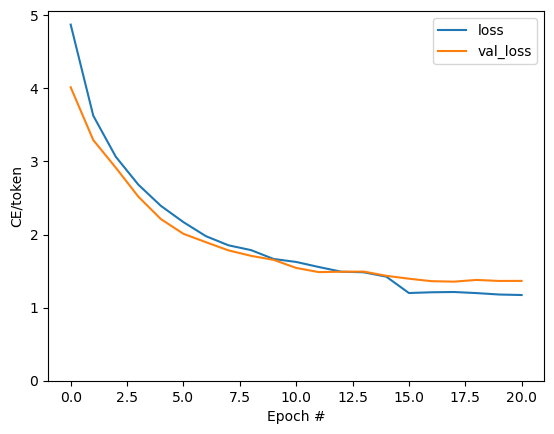

In [63]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

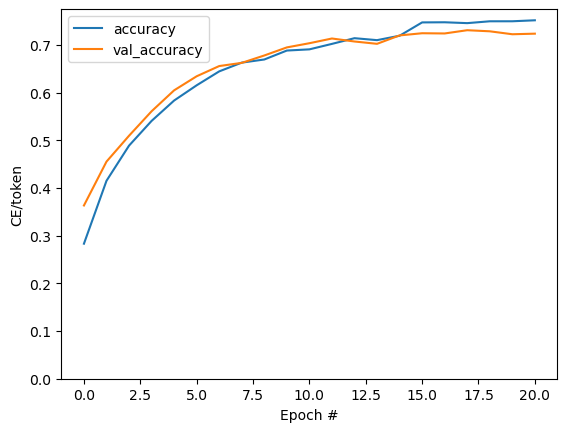

In [64]:
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Translate 

Now, we will implement a function to execute the full text => text translation

In [65]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [66]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

is running!!


'is he still home ? '

In [51]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

is running!!


/var/folders/qj/_xr448610yg3dn_k91tss4s80000gn/T/ipykernel_2938/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/qj/_xr448610yg3dn_k91tss4s80000gn/T/ipykernel_2938/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


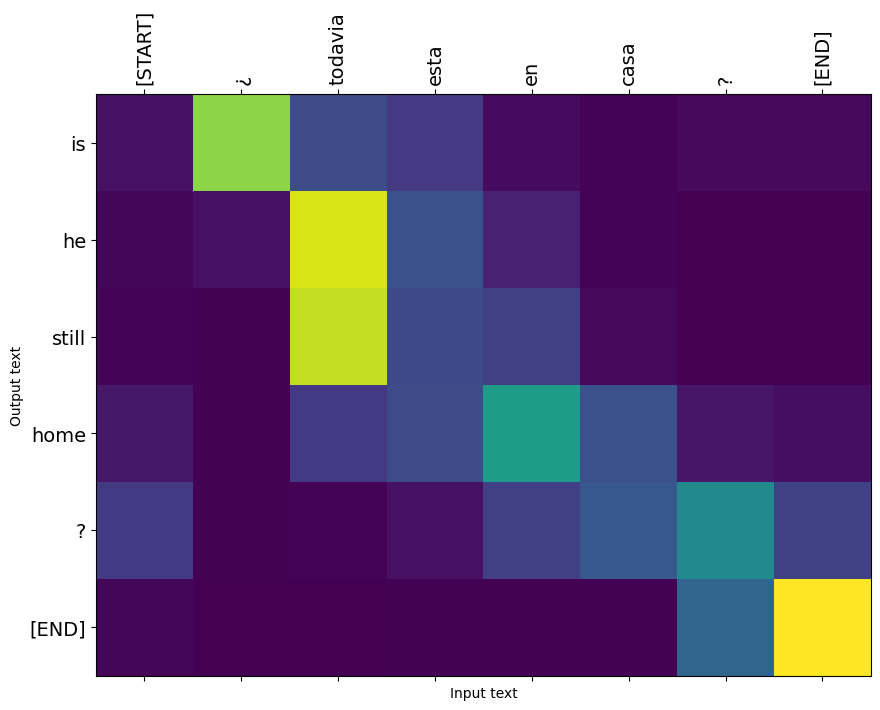

In [52]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


is running!!
CPU times: user 353 ms, sys: 21.7 ms, total: 374 ms
Wall time: 127 ms


/var/folders/qj/_xr448610yg3dn_k91tss4s80000gn/T/ipykernel_2938/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/qj/_xr448610yg3dn_k91tss4s80000gn/T/ipykernel_2938/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


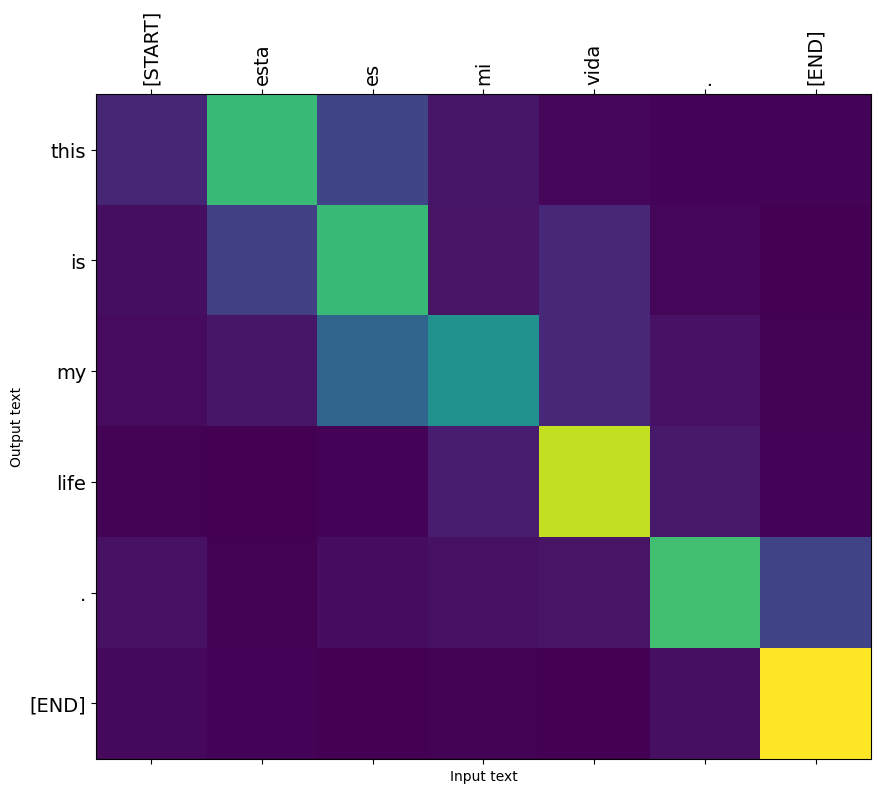

In [53]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

In [54]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


is running!!


/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/var/folders/qj/_xr448610yg3dn_k91tss4s80000gn/T/ipykernel_2938/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=

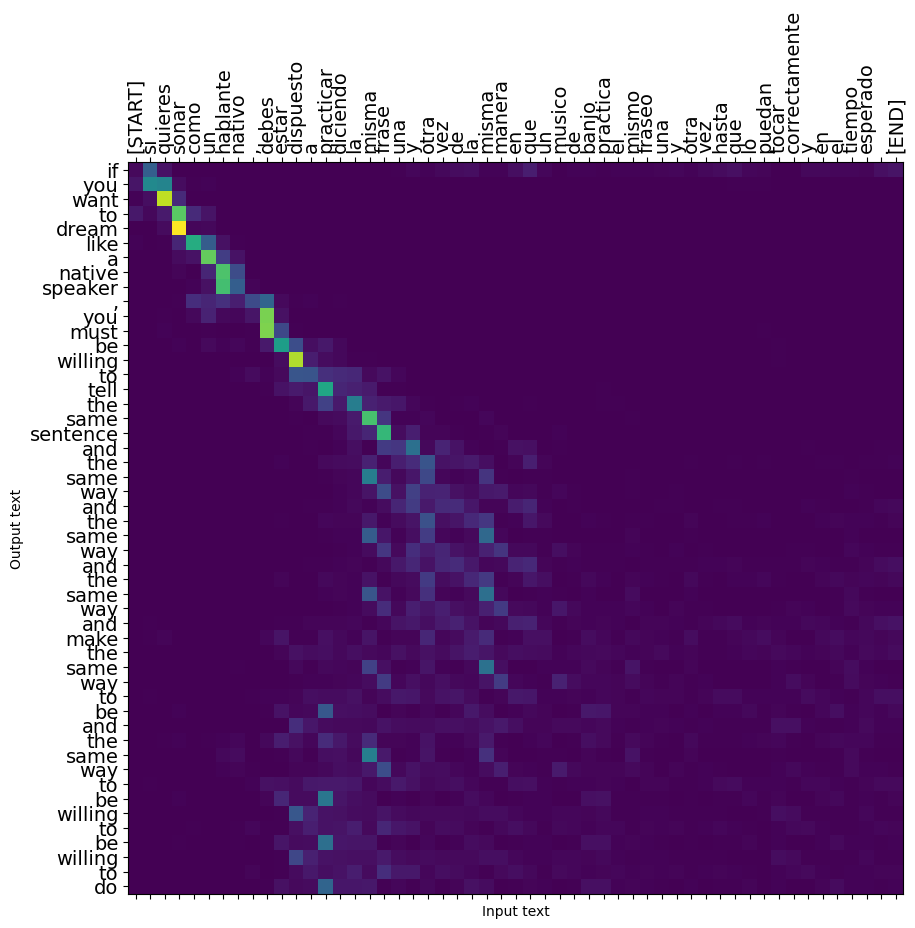

In [55]:
model.plot_attention(long_text)

In [56]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [57]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

is running!!
its a cold here . 
is running!!
this is my life . 
is running!!


/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/anaconda3/envs/sequence-to-sequence-model/lib/python3.9/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


his room is a disaster . 

CPU times: user 269 ms, sys: 20.7 ms, total: 289 ms
Wall time: 271 ms


In [58]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

is running!!
its a cold here .  
this is my life .  
his room is a disaster . 

CPU times: user 100 ms, sys: 10.9 ms, total: 111 ms
Wall time: 102 ms


### Save the Model 

In [59]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [60]:
export = Export(model)

In [67]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its a cold here .                                             
this is my life .                                             
his room is a disaster .                                            

CPU times: user 106 ms, sys: 84 ms, total: 190 ms
Wall time: 212 ms


SUMMARY - Although, the model is surely perfoming good, It could have done much better If a GPU was used. Unfortunately tensorflow-metal had some issues running with tensorflow-text, so i temporarily switched to CPU, but will try to look into the problem sometime later.